# Guiding diffusion models for sparse data reconstruction

In [1]:
%load_ext autoreload
%autoreload 2

import yaml
import os
import torch
import numpy as np
import matplotlib.pyplot as plt

from utils import *
from diffusion import Diffusion
from networks import Model
from datasets import KolmogorovFlowDataset
from residuals import ResidualOp

In [2]:
with open(os.path.join('configs', "kmflow_re1000_rs256.yml"), 'r') as f:
    config = yaml.safe_load(f)
config = dict2namespace(config)

In [3]:
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
config.device = device
config.seed = 1234

fix_randomness(config.seed)

In [ ]:
diffusion = Diffusion(config)
model = Model(config)
scaler = StdScaler()

model.load_state_dict(torch.load("pretrained_weights/checkpoint.pt"))
model.to(device);

## Generate samples

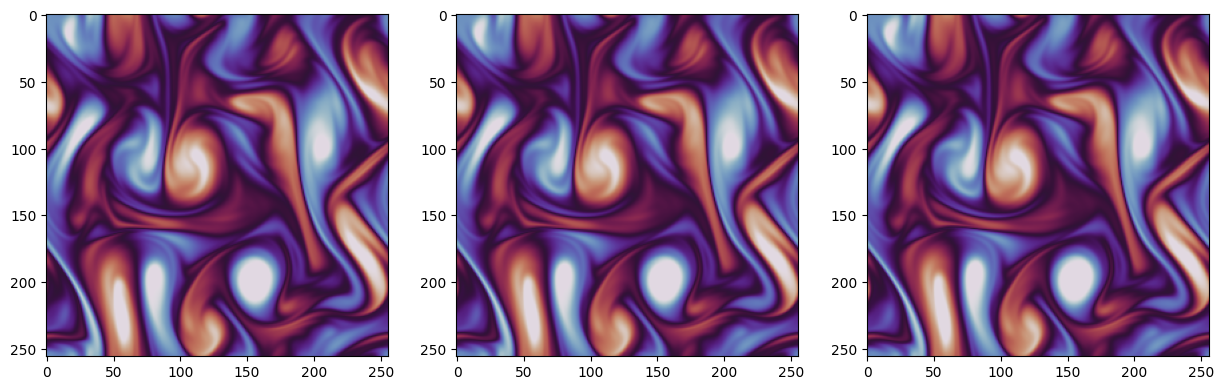

In [5]:
n_samples = 2
image_size = 256

model_input = torch.randn(n_samples, 3, image_size, image_size, device=device)
gen_samples = diffusion.ddpm(model_input, model)

plot_three(gen_samples[0, 0], gen_samples[0, 1], gen_samples[0, 2])

## Create Gaussian mask

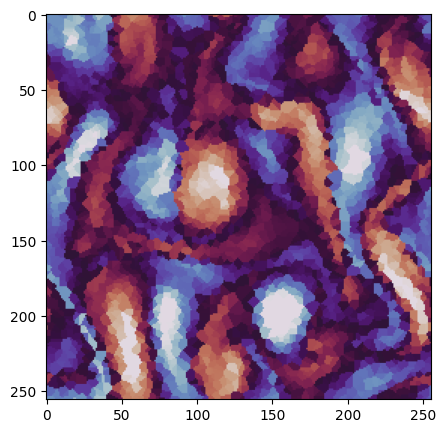

In [6]:
perc = 5/100
sig = 0.038 # Best value for 5%

interpolated_samples, sparse_ids = interpolate_dataset(gen_samples, perc)

interpolated_samples = interpolated_samples.to(device)

plot_field(interpolated_samples[0, 1], colorbar=False)

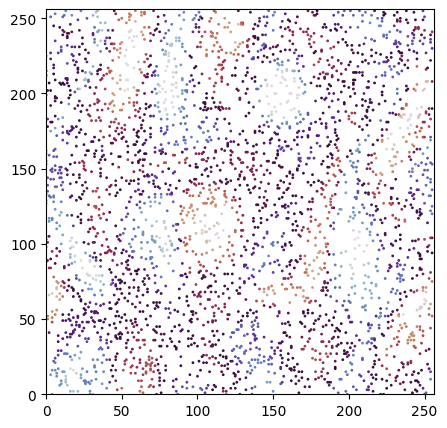

In [9]:
flat_sample = gen_samples[0,0].flatten().cpu()
X = [sid % 256 for sid in sparse_ids[0]]
Y = [(sid // 256)  for sid in sparse_ids[0]]
data = [flat_sample[sid] for sid in sparse_ids[0]]

fig, axes = plt.subplots(1, figsize=(5, 5))
axes.scatter(X, Y, c=data, cmap="twilight", vmin=-2, vmax=2, s=1)
axes.set_ylim(0, 256)
axes.set_xlim(0, 256)
plt.show()

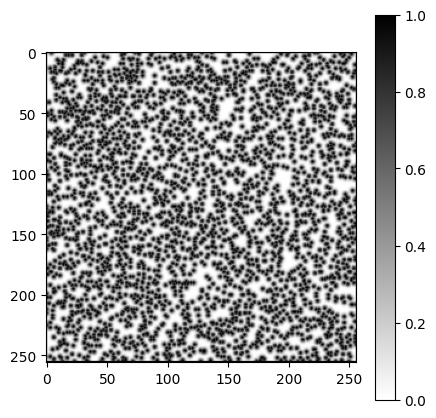

In [8]:
gaussian_masks = gen_gaussian_masks(sparse_ids, sig).to(device)

plot_field(gaussian_masks[0, 0], cmap="gist_yarg", vmin=0, vmax=1, colorbar=True)

In [14]:
x_T = torch.randn(interpolated_samples.shape, device=device)

x_0_pred, _ = diffusion.masked_diffusion(x_T, model, interpolated_samples, diff_mask=gaussian_masks)

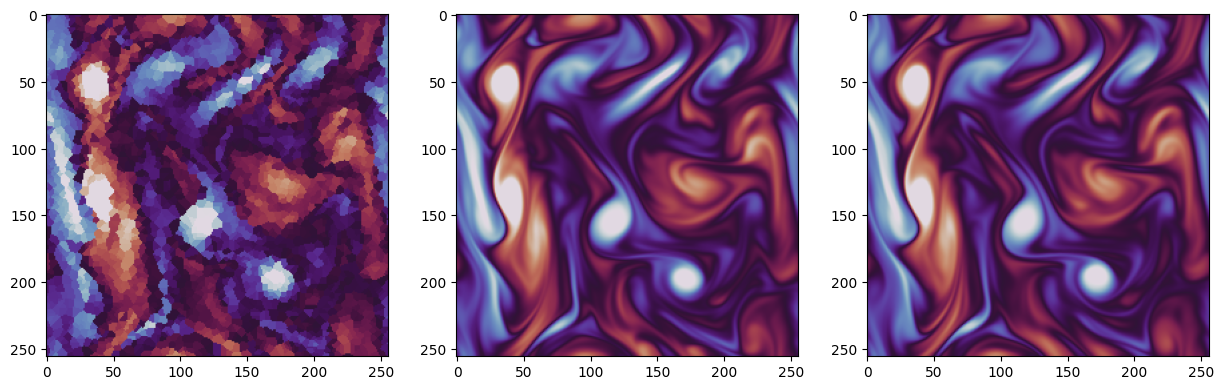

In [ ]:
plot_three(interpolated_samples[0,0], x_0_pred[0,0], gen_samples[0,0])